##### Mediapipe 姿勢偵測 ( Pose )
這篇教學會使用 MediaPipe 的姿勢偵測模型 ( pose ) 偵測人體姿勢，再透過 OpenCV 讀取攝影鏡頭影像進行辨識，\
將頭手四肢軀幹標記出對應的節點以及骨架，最後甚至還可透過偵測到的姿勢，作出即時去背的效果。

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 使用 MediaPipe，偵測姿勢並繪製骨架 
Mediapipe Pose 模型可以標記出身體共 33 個姿勢節點的位置，甚至可以進一步透過這些節點，\
將人物與背景分離，做到去背的效果，下圖標示出每個節點的順序和位置 ( [圖片來源](https://google.github.io/mediapipe/solutions/pose#python-solution-api) )。

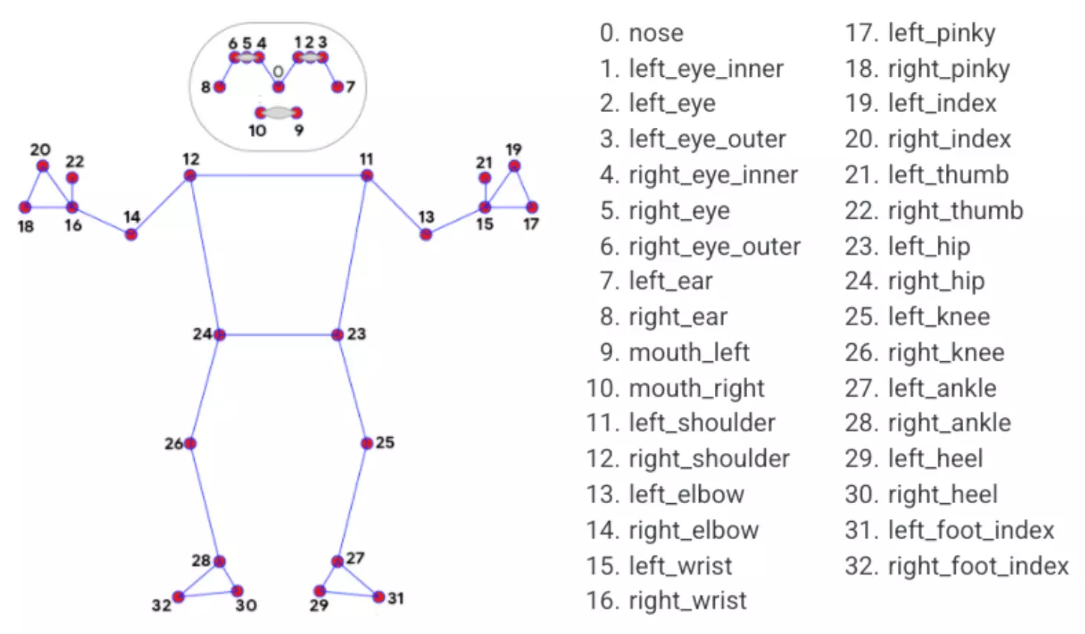

下方的程式碼延伸「[讀取並播放影片](https://steam.oxxostudio.tw/category/python/ai/opencv-read-video.html)」文章的範例，搭配 mediapipe 姿勢偵測的方法，透過攝影鏡頭獲取影像後，即時標記出身體骨架和動作。

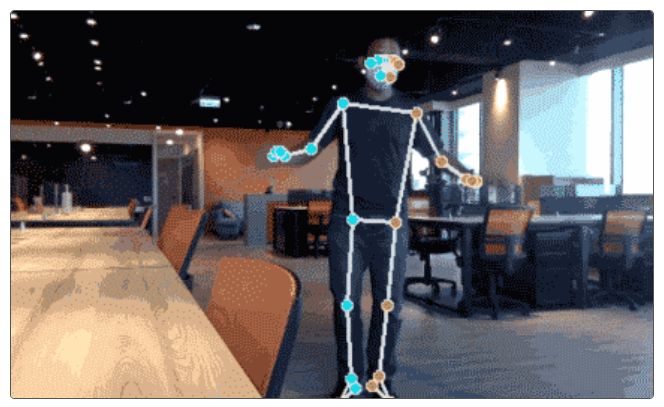

In [ ]:
import cv2
import mediapipe as mp

# 初始化 mediapipe 的繪圖工具和姿勢偵測模組
mp_drawing = mp.solutions.drawing_utils          # mediapipe 繪圖方法
mp_drawing_styles = mp.solutions.drawing_styles  # mediapipe 繪圖樣式
mp_pose = mp.solutions.pose                      # mediapipe 姿勢偵測

# 開啟攝影機
cap = cv2.VideoCapture(0)

# 啟用姿勢偵測
with mp_pose.Pose(
    min_detection_confidence=0.5,  # 最小偵測信心值
    min_tracking_confidence=0.5) as pose:  # 最小追蹤信心值

    if not cap.isOpened():
        print("Cannot open camera")  # 無法開啟攝影機
        exit()
    
    while True:
        ret, img = cap.read()  # 讀取攝影機影像
        if not ret:
            print("Cannot receive frame")  # 無法接收影像
            break
        
        img = cv2.resize(img, (1080, 720))  # 縮小尺寸，加快演算速度
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將 BGR 轉換成 RGB
        
        results = pose.process(img2)  # 取得姿勢偵測結果
        
        # 根據姿勢偵測結果，標記身體節點和骨架
        mp_drawing.draw_landmarks(
            img,  # 原始影像
            results.pose_landmarks,  # 姿勢偵測結果中的身體節點
            mp_pose.POSE_CONNECTIONS,  # 身體節點之間的連接
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()  # 標記樣式
        )

        cv2.imshow('oxxostudio', img)  # 顯示影像
        if cv2.waitKey(5) == ord('q'):
            break  # 按下 q 鍵停止
        
cap.release()  # 釋放攝影機資源
cv2.destroyAllWindows()  # 關閉所有 OpenCV 視窗

##### 透過姿勢偵測，進行即時去背 
若額外設定 enable_segmentation 參數為 True，則會透過姿勢判斷人體，進一步做到去背的效果，下方的程式碼會將人物背景換成 windows 的經典背景。

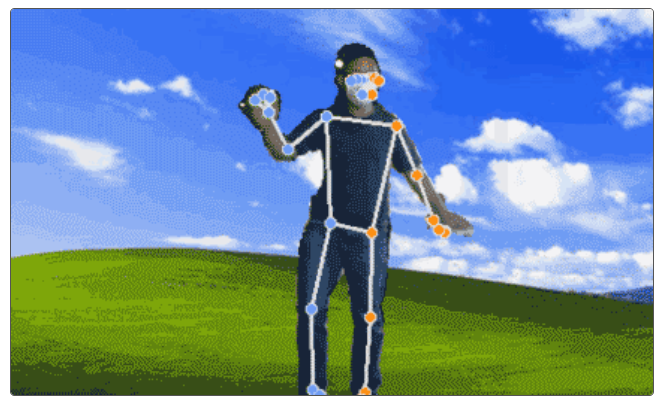

In [ ]:
import cv2
import mediapipe as mp
import numpy as np

# 初始化 mediapipe 的繪圖工具和姿勢偵測模組
mp_drawing = mp.solutions.drawing_utils          # mediapipe 繪圖方法
mp_drawing_styles = mp.solutions.drawing_styles  # mediapipe 繪圖樣式
mp_pose = mp.solutions.pose                      # mediapipe 姿勢偵測

# 開啟攝影機
cap = cv2.VideoCapture(0)

# 載入背景圖片
bg = cv2.imread(r'Img/Car/2.jpg')   # 載入背景

# 啟用姿勢偵測
with mp_pose.Pose(
    min_detection_confidence=0.5,  # 最小偵測信心值
    enable_segmentation=True,      # 啟用背景分割
    min_tracking_confidence=0.5) as pose:  # 最小追蹤信心值

    if not cap.isOpened():
        print("Cannot open camera")  # 無法開啟攝影機
        exit()
    
    while True:
        ret, img = cap.read()  # 讀取攝影機影像
        if not ret:
            print("Cannot receive frame")  # 無法接收影像
            break
        
        img = cv2.resize(img, (1024, 580))  # 縮小尺寸，加快演算速度
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 將 BGR 轉換成 RGB
        
        results = pose.process(img2)  # 取得姿勢偵測結果
        
        try:
            # 使用 try 避免抓不到姿勢時發生錯誤
            condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
            # 如果滿足模型判斷條件 ( 表示要換成背景 )，回傳 True
            img = np.where(condition, img, bg)
            # 將主體與背景合成，如果滿足背景條件，就更換為 bg 的像素，不然維持原本的 img 的像素
        except:
            pass
        
        # 根據姿勢偵測結果，標記身體節點和骨架
        mp_drawing.draw_landmarks(
            img,  # 原始影像
            results.pose_landmarks,  # 姿勢偵測結果中的身體節點
            mp_pose.POSE_CONNECTIONS,  # 身體節點之間的連接
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style()  # 標記樣式
        )

        cv2.imshow('oxxostudio', img)  # 顯示影像
        if cv2.waitKey(5) == ord('q'):
            break  # 按下 q 鍵停止
        
cap.release()  # 釋放攝影機資源
cv2.destroyAllWindows()  # 關閉所有 OpenCV 視窗

參考資料 
* [MediaPipe Pose](https://google.github.io/mediapipe/solutions/pose#python-solution-api)